# Dependencies

In [131]:
# Dependencies and Setup
%matplotlib inline
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy.stats import sem
import os
import datetime
import matplotlib as mpl
# geopandas
# sampling datasets

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# Functions used to clean and process data

In [132]:
def retrieve_summary(zone_lkup_file, taxi_file_names, gb_field):
    taxi_zone_lkup_df = pd.read_csv(zone_lkup_file)
    # chunk_list = []  # append each chunk df here     
    gb_field_list = ["trip_count","total_revenue","total_time_min","total_miles"]

    gb_final_file_df = pd.DataFrame()

    for file_key in taxi_file_names: 
        clean_file_df = clean_file(taxi_file_names[file_key], taxi_zone_lkup_df, file_key, gb_field)
        gb_clean_file_df = groupby(clean_file_df, gb_field, gb_field_list)
        gb_final_file_df = gb_final_file_df.append(gb_clean_file_df)
        print(file_key)

    gb_final_file_df = groupby(gb_final_file_df, gb_field, gb_field_list)
    gb_final_file_df = enrich_summary(gb_final_file_df)
    
    return gb_final_file_df

def enrich_summary(df):
    new_df = df
    new_df['avg_min_ptrip'] = new_df['total_time_min']/new_df['trip_count']
    new_df['avg_dist_ptrip'] = new_df['total_miles']/new_df['trip_count']
    new_df['avg_rev_ptrip'] = new_df['total_revenue']/new_df['trip_count']
    
    new_df['avg_dist_pmin'] = new_df['total_miles']/new_df['total_time_min']
    new_df['avg_rev_pmin'] = new_df['total_revenue']/new_df['total_time_min']
    
    return new_df


def clean_file(csv, taxi_zone_lkup_df, file_key, gb_field):
    
    chunks_df = pd.read_csv(csv, chunksize=1000000)    
    gb_field_list = ["PULocationID","total_amount","trip_time_min","trip_distance"]
    
    new_gb_df = pd.DataFrame()    
    
    print(gb_field)
    
    for chunk_df in chunks_df:  
        clean_chunk_df = clean_chunk(chunk_df, taxi_zone_lkup_df, file_key)
        gb_clean_chunk_df = groupby(clean_chunk_df, gb_field, gb_field_list)
        # Once the data filtering is done, append the chunk to list
        new_gb_df = new_gb_df.append(gb_clean_chunk_df)
    return new_gb_df


def clean_chunk(df, zone_lkup_df, file_key):
    new_df = remove_unwanted_columns(df)
    new_df = remove_unwanted_rows(new_df, file_key)
    new_df = add_new_columns(new_df, zone_lkup_df)
    return new_df

def remove_unwanted_columns(df):
    new_df = df.drop(['VendorID', 'store_and_fwd_flag','fare_amount',
                    'extra', 'mta_tax','tolls_amount',
                    'improvement_surcharge'], axis=1) 
    return new_df

def remove_unwanted_rows(df, file_key):
    new_df = df 
    new_df['year'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).year
    new_df['month'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).month
    
    file_month = file_key.split("_")[1]
    file_year = file_key.split("_")[0] 

    new_df = new_df.loc[(new_df["month"] == float(file_month)) & 
                        (new_df["year"] == float(file_year)), :]

    return new_df

def add_new_columns(df, zone_lkup_df):
    #set convert lkup_df to dictionary to leverage 'map' method
    taxi_zone_dic = pd.Series(zone_lkup_df.Zone.values, index=zone_lkup_df.LocationID).to_dict()

    new_df = df
    #creating 6 columns
    new_df['PU_zone_name'] = new_df.PULocationID.map(taxi_zone_dic)
    new_df['DO_zone_name'] = new_df.DOLocationID.map(taxi_zone_dic)

    #create 2 columns for time
    new_df['trip_time'] = pd.to_datetime(new_df["tpep_dropoff_datetime"]) - pd.to_datetime(new_df["tpep_pickup_datetime"])
    new_df['trip_time_min'] = new_df['trip_time'].dt.total_seconds()/60
    
    new_df['day_of_week'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.day_name()
    new_df['hour_of_day'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.hour

    
    return new_df

def groupby(df, gb_field_name, fields):
    
    groupby = df.groupby([gb_field_name])
    gb_trip_rev_total = groupby[fields[1]].sum()
    gb_trip_time_total = groupby[fields[2]].sum()
    gb_trip_miles_total = groupby[fields[3]].sum()
    
    if fields[0] == 'trip_count':
        gb_trip_count = groupby[fields[0]].sum()
    else:
        gb_trip_count = groupby[fields[0]].count()
        
    new_df = pd.DataFrame({"trip_count": gb_trip_count,
                          "total_revenue": gb_trip_rev_total,
                          "total_time_min": gb_trip_time_total,
                          "total_miles": gb_trip_miles_total})
    
    return new_df

def format_summary(df):
    new_df = df
    new_df['trip_count'] = new_df['trip_count'].map('{:,.2f}'.format)
    new_df['total_revenue'] = new_df['total_revenue'].map('${:,.2f}'.format)
    new_df['total_time_min'] = new_df['total_time_min'].map('{:,.2f}'.format)
    new_df['total_miles'] = new_df['total_miles'].map('{:,.2f}'.format)
    new_df['avg_min_ptrip'] = new_df['avg_min_ptrip'].map('{:,.2f}'.format)
    new_df['avg_dist_ptrip'] = new_df['avg_dist_ptrip'].map('{:,.2f}'.format)
    new_df['avg_rev_ptrip'] = new_df['avg_rev_pmin'].map('${:,.2f}'.format)
    new_df['avg_dist_pmin'] = new_df['avg_dist_pmin'].map('{:,.2f}'.format)
    new_df['avg_rev_pmin'] = new_df['avg_rev_pmin'].map('${:,.2f}'.format)
    
    return new_df

# Pointers at data

In [4]:
# Storing Filenames to Load
taxi_file_names = {
#     "2018_01": os.path.join("..", "TaxiData", "yellow_tripdata_2018-01.csv"),
#     "2018_02": os.path.join("..", "TaxiData", "yellow_tripdata_2018-02.csv"),
#     "2018_03": os.path.join("..", "TaxiData", "yellow_tripdata_2018-03.csv"),
#     "2018_04": os.path.join("..", "TaxiData", "yellow_tripdata_2018-04.csv"),
#     "2018_05": os.path.join("..", "TaxiData", "yellow_tripdata_2018-05.csv"),
#     "2018_06": os.path.join("..", "TaxiData", "yellow_tripdata_2018-06.csv"),
#     "2018_07": os.path.join("..", "TaxiData", "yellow_tripdata_2018-07.csv"),
#     "2018_08": os.path.join("..", "TaxiData", "yellow_tripdata_2018-08.csv"),
#     "2018_09": os.path.join("..", "TaxiData", "yellow_tripdata_2018-09.csv"),
#     "2018_10": os.path.join("..", "TaxiData", "yellow_tripdata_2018-10.csv"),
#     "2018_11": os.path.join("..", "TaxiData", "yellow_tripdata_2018-11.csv"),
    "2018_12": os.path.join("..", "TaxiData", "yellow_tripdata_2018-12.csv")
}
                              
taxi_zone_lkup_csv = os.path.join("..","TaxiData", "taxi_zone_lookup.csv")

In [122]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=50)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=50)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        c=plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
        mpl.rcParams.update({'font.size': 30})
        
        
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=30,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [134]:
# df_info = retrieve_summary(taxi_zone_lkup_csv["2018_12"], taxi_file_names, "PULocationID")
csv = taxi_file_names["2018_12"]
chunks_df = pd.read_csv(csv, chunksize=1000000)
# chunks_df[0].info(memory_usage='deep')

In [107]:
df_PU = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "PULocationID")
df_PU = df_PU.reset_index()
df_PU.head()
# group = "PU_zone_name, PULocationID" 
# print(group)

# kev = group.split(',')
# print(kev)
      

PULocationID
2018_12


PULocationID  trip_count  total_revenue  total_time_min  total_miles  \
0             1         664       62013.46     3830.566667      1313.39   
1             2           9         386.64      288.400000       109.02   
2             3         163        5330.92     4368.416667      1422.45   
3             4       16666      246121.18   275758.000000     44024.06   
4             5          14        1093.76      720.250000       266.05   

   avg_min_ptrip  avg_dist_ptrip  avg_rev_ptrip  avg_dist_pmin  avg_rev_pmin  
0       5.768926        1.977997      93.393765       0.342871     16.189109  
1      32.044444       12.113333      42.960000       0.378017      1.340638  
2      26.800102        8.726687      32.705031       0.325621      1.220332  
3      16.546142        2.641549      14.767862       0.159647      0.892526  
4      51.446429       19.003571      78.125714       0.369386      1.518584

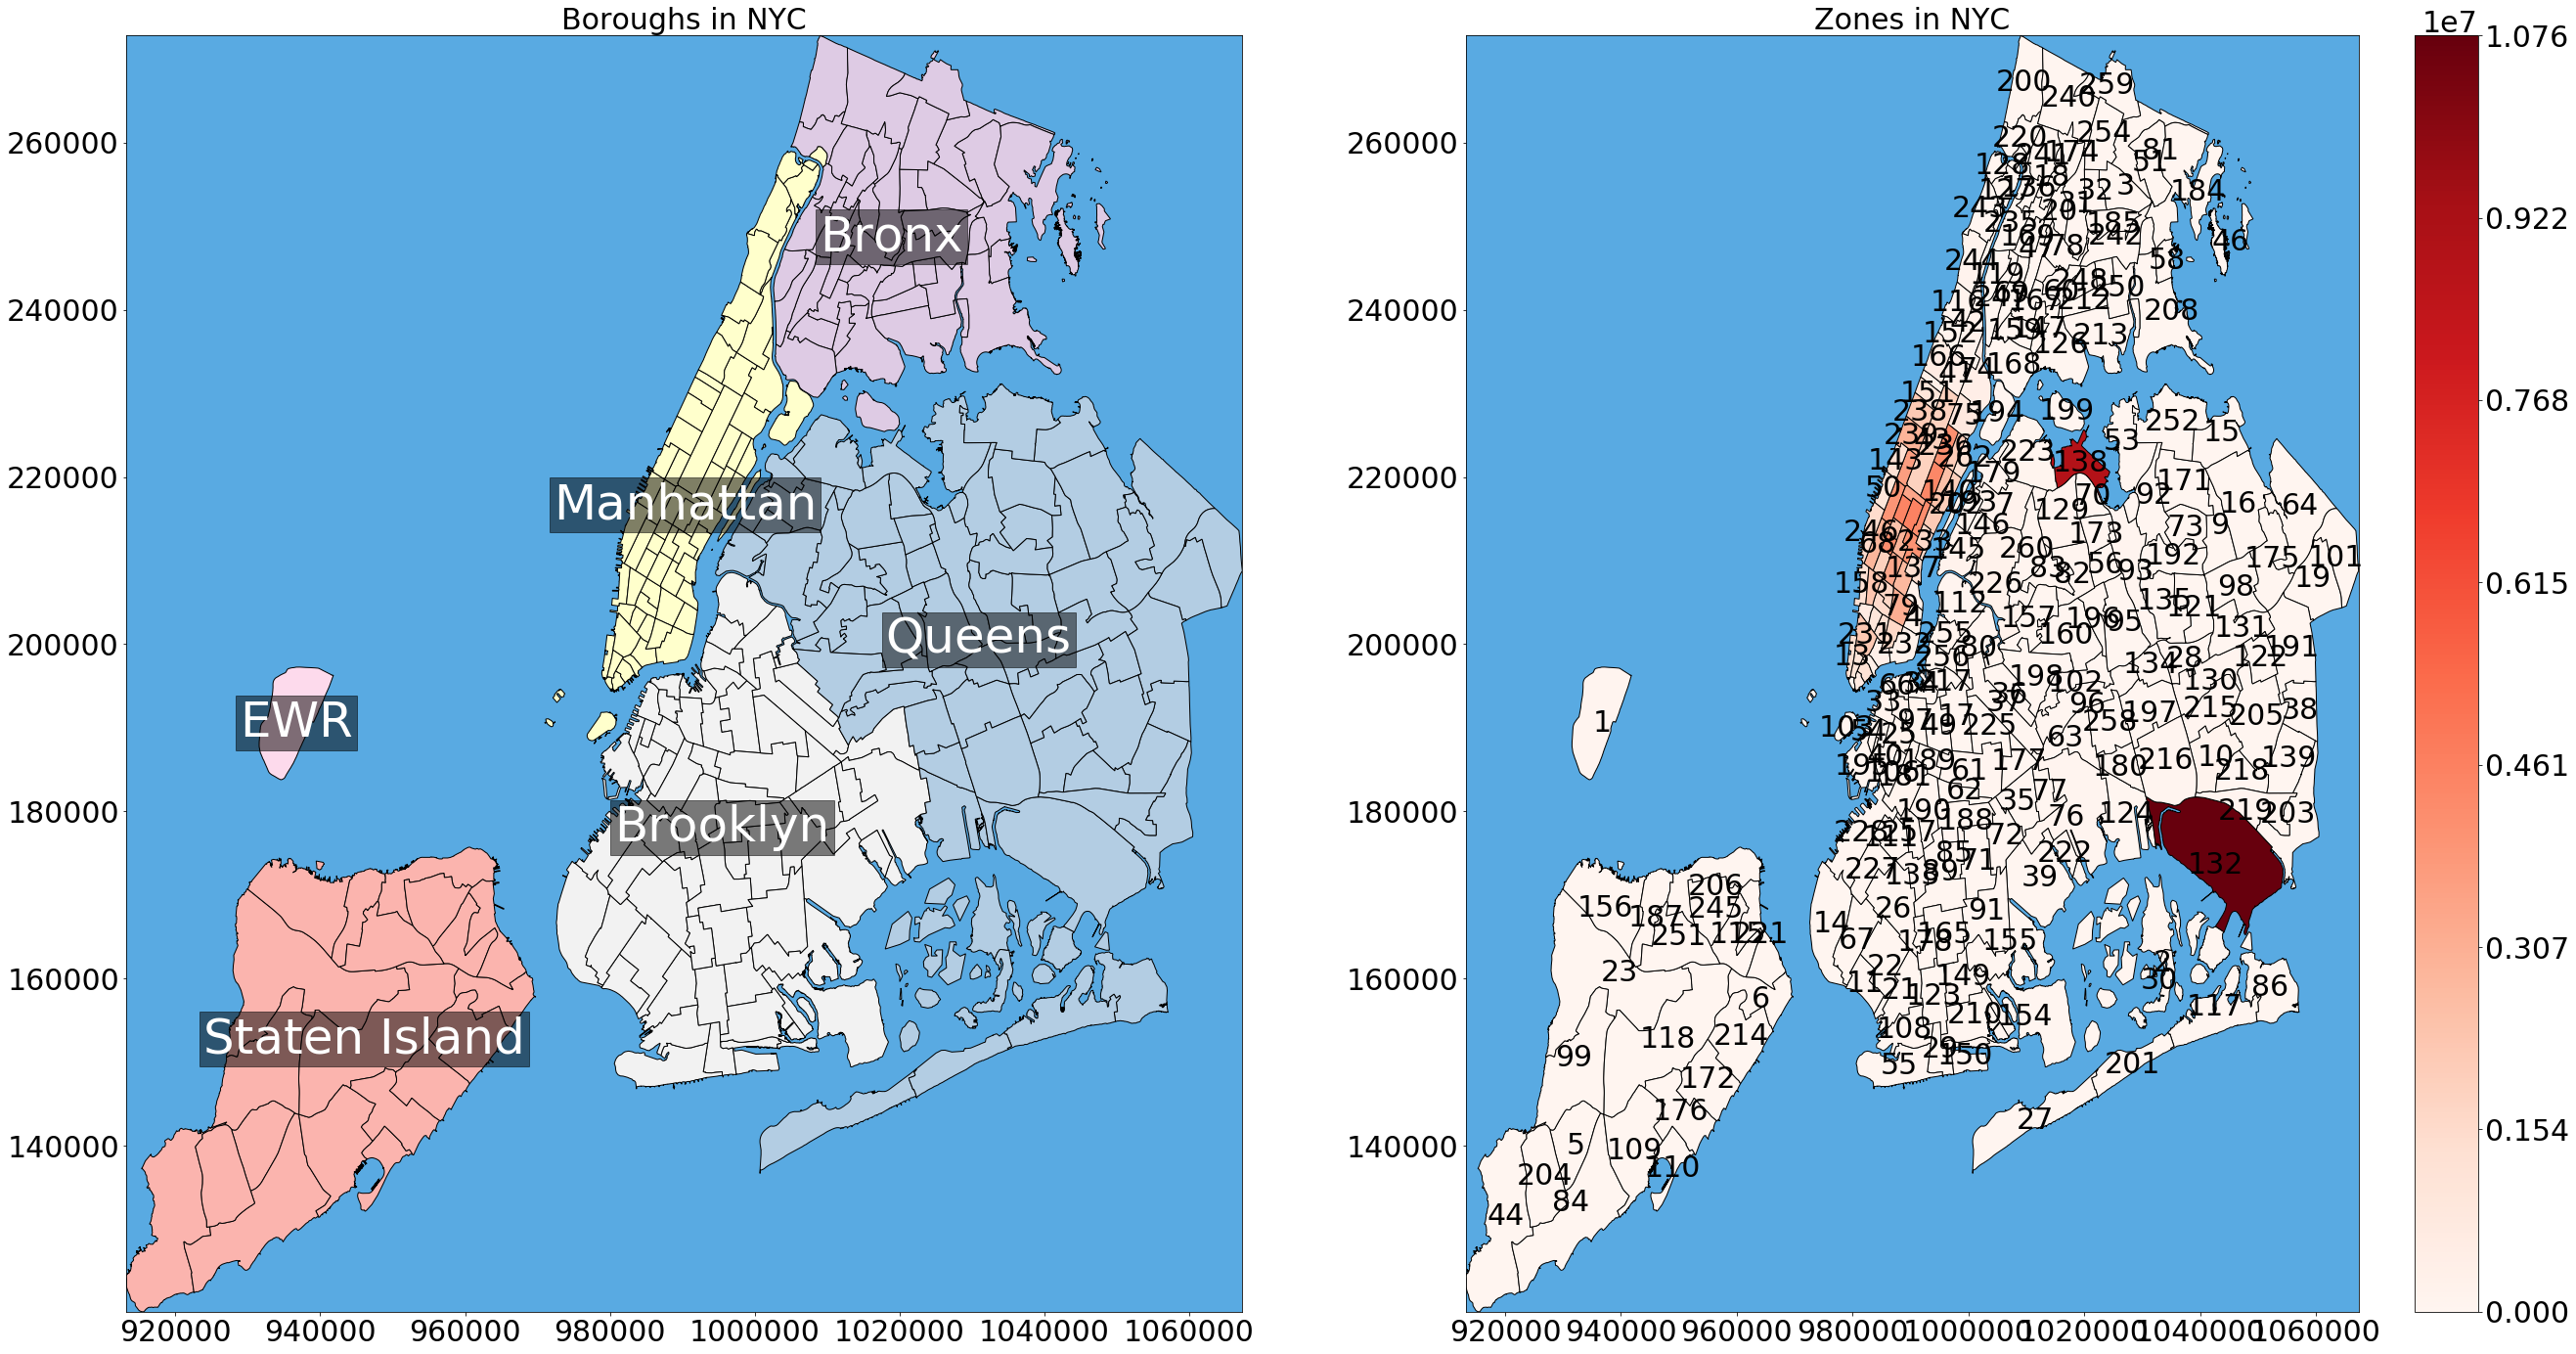

In [124]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(45,24))

ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)


PUrev = dict(zip(df_PU['PULocationID'].tolist(), df_PU['total_revenue'].tolist()))

ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, heat=PUrev)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(30)

# plt.colorbar().set_label(label='a label',size=30,weight='bold')    

In [5]:
#################
'variable names'
#################
'PU_zone_name'
'month'    
'day_of_week'
'hour_of_day'    
'RatecodeID'     
#################
start = datetime.datetime.today()

#retrieves a summary from a years worth of data for a given variable
df_PU_zone_name_1YR = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "PU_zone_name")

df_month_1YR = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "month")

df_DOW_1YR = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "day_of_week")

df_HOD_1YR = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "hour_of_day")

df_passenger_cnt_1YR = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "passenger_count")

end = datetime.datetime.today()
print(end - start)

print("processing complete!")

2018_12
0:00:51.465588
2018_12
0:01:42.403414
2018_12
0:02:34.838712
2018_12
0:03:25.131264
2018_12
0:04:16.501932
processing complete!


In [6]:
df_month_1YR

trip_count  total_revenue  total_time_min  total_miles  avg_min_ptrip  \
month                                                                          
12        8172312   1.350406e+08    1.531619e+08  23638640.75      18.741557   

       avg_dist_ptrip  avg_rev_ptrip  avg_dist_pmin  avg_rev_pmin  
month                                                              
12           2.892528      16.524165       0.154338      0.881686

In [8]:
df_DOW_1YR

trip_count  total_revenue  total_time_min  total_miles  \
day_of_week                                                           
Friday          1146734   1.939565e+07    2.253313e+07   3320120.65   
Monday          1212860   1.949965e+07    2.093556e+07   3505801.78   
Saturday        1388930   2.172764e+07    2.603594e+07   3838846.86   
Sunday          1194161   1.913649e+07    2.089952e+07   3633013.02   
Thursday        1134030   1.978058e+07    2.306866e+07   3319028.20   
Tuesday         1005519   1.674726e+07    1.881055e+07   2877540.07   
Wednesday       1090078   1.875336e+07    2.087849e+07   3144290.17   

             avg_min_ptrip  avg_dist_ptrip  avg_rev_ptrip  avg_dist_pmin  \
day_of_week                                                                
Friday           19.649831        2.895284      16.913815       0.147344   
Monday           17.261317        2.890525      16.077414       0.167457   
Saturday         18.745321        2.763888      15.643439       0.147444   
Sunday           17.501429        3.042314      16.025048       0.173832   
Thursday         20.342191        2.926755      17.442731       0.143876   
Tuesday          18.707308        2.861746      16.655342       0.152975   
Wednesday        19.153206        2.884463      17.203687       0.150600   

             avg_rev_pmin  
day_of_week                
Friday           0.860761  
Monday           0.931413  
Saturday         0.834525  
Sunday           0.915642  
Thursday         0.857466  
Tuesday          0.890312  
Wednesday        0.898214

In [7]:
df_HOD_1YR

trip_count  total_revenue  total_time_min  total_miles  \
hour_of_day                                                           
0                274532   4.575403e+06    4.725366e+06    898278.31   
1                192518   3.019724e+06    3.140778e+06    598072.96   
2                137152   2.073617e+06    2.136937e+06    413536.92   
3                 95843   1.519555e+06    1.537491e+06    315562.79   
4                 73876   1.364339e+06    1.196050e+06    303298.37   
5                 76212   1.543014e+06    1.495825e+06    348097.16   
6                166293   2.756315e+06    2.882204e+06    591777.10   
7                275440   4.281873e+06    5.127404e+06    824828.38   
8                341160   5.300725e+06    6.145789e+06    935079.66   
9                365148   5.607465e+06    6.568629e+06    961528.82   
10               391500   6.185974e+06    7.025968e+06   1033874.51   
11               415208   6.492768e+06    7.819073e+06   1073724.83   
12               441691   7.313704e+06    8.343002e+06   1171657.36   
13               447328   7.301792e+06    8.846294e+06   1251117.79   
14               467864   7.813723e+06    9.726434e+06   1338523.25   
15               465811   7.836232e+06    9.839093e+06   1317858.31   
16               420343   7.819394e+06    9.276348e+06   1240011.56   
17               462104   8.060241e+06    9.684194e+06   1282260.09   
18               505797   8.404274e+06    9.829898e+06   1321323.24   
19               487403   7.942816e+06    8.787990e+06   1302218.46   
20               448886   7.292124e+06    7.903766e+06   1290148.89   
21               447468   7.456365e+06    7.824786e+06   1363897.98   
22               420855   7.091029e+06    7.242039e+06   1314964.15   
23               351880   5.988167e+06    6.056494e+06   1146999.86   

             avg_min_ptrip  avg_dist_ptrip  avg_rev_ptrip  avg_dist_pmin  \
hour_of_day                                                                
0                17.212441        3.272035      16.666191       0.190097   
1                16.314206        3.106582      15.685412       0.190422   
2                15.580792        3.015172      15.119120       0.193519   
3                16.041762        3.292497      15.854632       0.205245   
4                16.189967        4.105506      18.467958       0.253583   
5                19.627154        4.567485      20.246335       0.232713   
6                17.332084        3.558641      16.575052       0.205321   
7                18.615319        2.994585      15.545576       0.160867   
8                18.014389        2.740883      15.537357       0.152150   
9                17.988951        2.633258      15.356691       0.146382   
10               17.946278        2.640803      15.800700       0.147150   
11               18.831702        2.585993      15.637386       0.137321   
12               18.888776        2.652663      16.558417       0.140436   
13               19.775855        2.796869      16.323128       0.141428   
14               20.789019        2.860924      16.700842       0.137617   
15               21.122501        2.829170      16.822771       0.133941   
16               22.068521        2.949999      18.602413       0.133675   
17               20.956742        2.774830      17.442483       0.132408   
18               19.434473        2.612359      16.615903       0.134419   
19               18.030233        2.671749      16.296198       0.148182   
20               17.607512        2.874113      16.244934       0.163232   
21               17.486806        3.048035      16.663459       0.174305   
22               17.207919        3.124506      16.849103       0.181574   
23               17.211816        3.259634      17.017640       0.189383   

             avg_rev_pmin  
hour_of_day                
0                0.968264  
1                0.961457  
2                0.970369  
3                0.988335  
4                1.14

In [112]:
df_passenger_cnt_1YR
df = format_summary(df_passenger_cnt_1YR)
df

trip_count   total_revenue  total_time_min    total_miles  \
passenger_count                                                                
0                  115,760.00   $2,264,601.76    1,693,970.98     321,089.59   
1                5,692,346.00  $92,967,985.61  104,496,672.45  16,236,556.21   
2                1,251,121.00  $21,291,485.96   23,917,409.87   3,777,570.83   
3                  371,961.00   $6,223,654.43    7,534,381.87   1,097,776.31   
4                  182,061.00   $3,102,488.88    3,423,278.03     549,976.64   
5                  346,924.00   $5,731,037.82    7,642,320.52   1,033,482.49   
6                  212,060.00   $3,454,804.09    4,452,106.33     621,866.67   
7                       31.00       $1,453.83          479.22          82.24   
8                       27.00       $1,768.80          944.58         135.28   
9                       21.00       $1,351.50          287.28         104.49   

                avg_min_ptrip avg_dist_ptrip avg_rev_ptrip avg_dist_pmin  \
passenger_count                                                            
0                       14.63           2.77         $1.34          0.19   
1                       18.36           2.85         $0.89          0.16   
2                       19.12           3.02         $0.89          0.16   
3                       20.26           2.95         $0.83          0.15   
4                       18.80           3.02         $0.91          0.16   
5                       22.03           2.98         $0.75          0.14   
6                       20.99           2.93         $0.78          0.14   
7                       15.46           2.65         $3.03          0.17   
8                       34.98           5.01         $1.87          0.14   
9                       13.68           4.98         $4.70          0.36   

                avg_rev_pmin  
passenger_count               
0                      $1.34  
1                      $0.89  
2                      $0.89  
3                      $0.83  
4                      $0.91  
5                      $0.75  
6                      $0.78  
7                      $3.03  
8                      $1.87  
9                      $4.70

In [11]:
taxi_zone_lkup_df = pd.read_csv(taxi_zone_lkup_csv)
taxi_zone_lkup_df

LocationID        Borough                                 Zone  \
0             1            EWR                       Newark Airport   
1             2         Queens                          Jamaica Bay   
2             3          Bronx              Allerton/Pelham Gardens   
3             4      Manhattan                        Alphabet City   
4             5  Staten Island                        Arden Heights   
5             6  Staten Island              Arrochar/Fort Wadsworth   
6             7         Queens                              Astoria   
7             8         Queens                         Astoria Park   
8             9         Queens                           Auburndale   
9            10         Queens                         Baisley Park   
10           11       Brooklyn                           Bath Beach   
11           12      Manhattan                         Battery Park   
12           13      Manhattan                    Battery Park City   
13           14       Brooklyn                            Bay Ridge   
14           15         Queens              Bay Terrace/Fort Totten   
15           16         Queens                              Bayside   
16           17       Brooklyn                              Bedford   
17           18          Bronx                         Bedford Park   
18           19         Queens                            Bellerose   
19           20          Bronx                              Belmont   
20           21       Brooklyn                     Bensonhurst East   
21           22       Brooklyn                     Bensonhurst West   
22           23  Staten Island              Bloomfield/Emerson Hill   
23           24      Manhattan                         Bloomingdale   
24           25       Brooklyn                          Boerum Hill   
25           26       Brooklyn                         Borough Park   
26           27         Queens  Breezy Point/Fort Tilden/Riis Beach   
27           28         Queens              Briarwood/Jamaica Hills   
28           29       Brooklyn                       Brighton Beach   
29           30         Queens                        Broad Channel   
..          ...            ...                                  ...   
235         236      Manhattan                Upper East Side North   
236         237      Manhattan                Upper East Side South   
237         238      Manhattan                Upper West Side North   
238         239      Manhattan                Upper West Side South   
239         240          Bronx                   Van Cortlandt Park   
240         241          Bronx                Van Cortlandt Village   
241         242          Bronx                 Van Nest/Morris Park   
242         243      Manhattan             Washington Heights North   
243         244      Manhattan             Washington Heights South   
244         245  Staten Island                        West Brighton   
245         246      Manhattan            West Chelsea/Hudson Yards   
246         247          Bronx                       West Concourse   
247         248          Bronx               West Farms/Bronx River   
248         249      Manhattan                         West Village   
249         250          Bronx        Westchester Village/Unionport   
250         251  Staten Island                          Westerleigh   
251         252         Queens                           Whitestone   
252         253         Queens                        Willets Point   
253         254          Bronx             Williamsbridge/Olinville   
254         255       Brooklyn            Williamsburg (North Side)   
255         256       Brooklyn            Williamsburg (South Side)   
256         257       Brooklyn                      Windsor Terrace   
257         258         Queens                            Woodhaven   
258         259          Bronx                   Woodlawn/Wakefield   
259         260         Queen

In [47]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [48]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

taxi_zone_shp = os.path.join("..","TaxiData", "taxi_zones.shp")
sf = shapefile.Reader(taxi_zone_shp)
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

LocationID  OBJECTID  Shape_Area  Shape_Leng        borough  \
0           1         1    0.000782    0.116357            EWR   
1           2         2    0.004866    0.433470         Queens   
2           3         3    0.000314    0.084341          Bronx   
3           4         4    0.000112    0.043567      Manhattan   
4           5         5    0.000498    0.092146  Staten Island   

                      zone     longitude       latitude  
0           Newark Airport  9.366817e+05  190522.130278  
1              Jamaica Bay  1.033536e+06  161853.982300  
2  Allerton/Pelham Gardens  1.027136e+06  254730.010849  
3            Alphabet City  9.904240e+05  203100.040432  
4            Arden Heights  9.321332e+05  139954.541936

In [ ]:
df_kev = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "hour_of_day")
df_kev

In [ ]:
df_kev = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "day_of_week")
df_kev

In [ ]:
df2_high_volume= df.loc[df['trip_count'] > 100000, :]


df2_high_volume.sort_values(by=['avg_rev_pmin'],ascending= False)

In [ ]:
trip_count = df['trip_count'].sum()
print("{:,}".format(trip_count))

In [ ]:
############ MESS AROUND BELOW HERE ##############################

gb = df.reset_index()
gb

In [ ]:
gb['PU_zone_name'].unique

In [ ]:
UES_df = df.loc[['Upper East Side North','Upper East Side South','Yorkville East']]

UES_df

In [ ]:
df = pd.read_csv(taxi_file_names["2018_12"])  
df =remove_unwanted_columns(df)
df = remove_unwanted_rows(df,"2018_12")
df = add_new_columns(df,taxi_zone_lkup_df)
df.head()

In [ ]:

jfk_df = gb_final_file_df.loc[['JFK Airport','Newark Airport','LaGuardia Airport']]

jfk_df

In [ ]:
gb_final_file_df.info(memory_usage='deep')

In [ ]:
df_concat.info(memory_usage='deep')

In [ ]:
gb_PU_summary_df.info(memory_usage='deep')